In [1]:
import re
import locale
import pandas as pd
import requests
import os

from webLib import textFromURLorFile
from bs4 import BeautifulSoup

# pd.set_option('display.max_rows', 100)

# Configura o locale para o formato de número brasileiro
locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')

'pt_BR.utf8'

In [4]:
url = 'https://sisgvarmazenamento.blob.core.windows.net/prd/PublicacaoPortal/Arquivos/202309.htm'
texto = textFromURLorFile(url, "dados-202309.txt")

# https://regex101.com/

for resultado in re.finditer(r"Vereador\(a\): (( |\.|\w+)*)\n(.+?)(?=Vereador)", texto, re.DOTALL):
    nome_vereador = resultado.group(1)
    dados = texto[resultado.start():resultado.end()]
    if "VEREADOR AFASTADO" in dados:
        continue

    total = re.search(r"TOTAL DO MÊS\s+([\d.,]+)", dados)
    valor = locale.atof(total.group(1))
    print("\n", valor, nome_vereador)

    for itens in re.finditer(r"(?P<item>.*)\s*(?P<subitem>(([\d.\/-]+)\s(.*)\s([\d.,]+)\s*)+)TOTAL DO ITEM\s+(?P<total>[\d.,]+)", dados):
        item = itens.group("item")
        valor = locale.atof(itens.group("total"))
        print("\t", valor, item)

In [5]:
ano = {}
for n in range(1, 8, 1):
    url = f'https://sisgvarmazenamento.blob.core.windows.net/prd/PublicacaoPortal/Arquivos/2023{n:02d}.htm'
    texto = textFromURLorFile(url, f"dados-2023{n:02d}.txt")

    for resultado in re.finditer(r"Vereador\(a\): (( |\.|\w+)*)\n(.+?)(?=Vereador)", texto, re.DOTALL):
        nome_vereador = resultado.group(1)
        dados = texto[resultado.start():resultado.end()]
        if "VEREADOR AFASTADO" in dados:
            continue

        total = re.search(r"TOTAL DO MÊS\s+([\d.,]+)", dados)
        valor = locale.atof(total.group(1))
        if nome_vereador not in ano:
            ano[nome_vereador] = {"total": 0}
            
        ano[nome_vereador]["total"] += valor

        for itens in re.finditer(r"(?P<item>.*)\s*(?P<subitem>(([\d.\/-]+)\s(.*)\s([\d.,]+)\s*)+)TOTAL DO ITEM\s+(?P<total>[\d.,]+)", dados):
            item = itens.group("item")
            valor = locale.atof(itens.group("total"))
            if item not in ano[nome_vereador]:
                ano[nome_vereador][item] = 0
            
            ano[nome_vereador][item] += valor

ano

{'ADILSON AMADEU': {'total': 93267.77,
  'INTERMEDIADO - LOCAÇÃO DE VEÍCULOS': 19300.26,
  'TELEFONE FIXO': 1464.1499999999999,
  'TELEFONE MOVEL': 6290.32,
  'COMPOSIÇÃO/ARTE/DIAGRAMAÇÃO/PRODUÇÃO/IMPRESSAO GRAFICA': 21000.0,
  'INTERMEDIADO - CORREIOS': 45213.04},
 'ALESSANDRO GUEDES': {'total': 195726.5,
  'COMBUSTIVEL': 4385.290000000001,
  'COMPOSIÇÃO/ARTE/DIAGRAMAÇÃO/PRODUÇÃO/IMPRESSAO GRAFICA': 58584.75,
  'CONTRATAÇAO DE PESSOA JURIDICA': 96673.69,
  'INTERMEDIADO - LOCAÇÃO DE VEÍCULOS': 19300.26,
  'LOCAÇÃO DE MOVEIS E EQUIPAMENTOS': 11970.0,
  'TELEFONE FIXO': 1339.89,
  'TELEFONE MOVEL': 1863.0200000000004,
  'ELABORAÇÃO/MANUTENÇAO DE SITE/HOSPEDAGEM': 288.7,
  'MATERIAL DE ESCRITORIO E OUTROS MATERIAIS DE CONSUMO': 1320.9},
 'ANDRÉ SANTOS': {'total': 147616.04,
  'COMBUSTIVEL': 9282.61,
  'COMPOSIÇÃO/ARTE/DIAGRAMAÇÃO/PRODUÇÃO/IMPRESSAO GRAFICA': 13961.0,
  'CONTRATAÇAO DE PESSOA JURIDICA': 89325.0,
  'INTERMEDIADO - LOCAÇÃO VEICULOS HIBRIDOS': 24764.989999999998,
  'EVENTOS/

In [6]:
df = pd.DataFrame.from_dict(ano, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'vereador'}, inplace=True)
df.fillna(0, inplace=True)
df = df.sort_values(by='total', ascending=False)
df = df.reset_index(drop=True)
df = df.round(2) # arredonda centavos
df.to_csv('sp-totais.csv', index=False)
df

,vereador,total,INTERMEDIADO - LOCAÇÃO DE VEÍCULOS,TELEFONE FIXO,TELEFONE MOVEL,COMPOSIÇÃO/ARTE/DIAGRAMAÇÃO/PRODUÇÃO/IMPRESSAO GRAFICA,INTERMEDIADO - CORREIOS,COMBUSTIVEL,CONTRATAÇAO DE PESSOA JURIDICA,LOCAÇÃO DE MOVEIS E EQUIPAMENTOS,...,REPROGRAFIA (XEROX/ENCADERNAÇÃO),ASSINATURA DE JORNAIS E REVISTAS,CORREIOS,ESTACIONAMENTO,INTERMEDIADO - REPROGRAFIA (XEROX/ENCADERNAÇÃO),LIVROS,LUBRIFICANTE,APERFEIÇOAMENTO PROFISSIONAL,LOCAÇÃO DE VEICULOS HIBRIDOS,LOCAÇÃO DE VEÍCULOS
0,EDIR SALES,224763.12,0.00,1619.09,0.0,30051.71,39073.06,4966.49,84914.53,8050.00,...,3415.5,0.0,17816.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,RODOLFO DESPACHANTE,224345.40,16910.70,0.00,0.0,54745.00,0.00,7905.20,103900.00,12780.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,JOÃO JORGE,222185.13,0.00,0.00,0.0,25085.00,0.00,12387.75,104099.91,30100.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,LUANA ALVES,219445.66,19300.26,0.00,0.0,24700.00,0.00,7976.53,107675.37,31570.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISAC FELIX,216122.44,19300.26,0.00,0.0,41570.00,0.00,14205.34,48370.00,36658.35,...,0.0,0.0,35220.77,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,ERIKA HILTON,17609.53,0.00,0.00,0.0,0.00,13490.30,477.32,0.00,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,FELIPE BECARI,14800.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,DELEGADO PALUMBO,13167.42,2757.18,0.00,0.0,0.00,0.00,0.00,10000.00,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,JOSÉ POLICE NETO,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


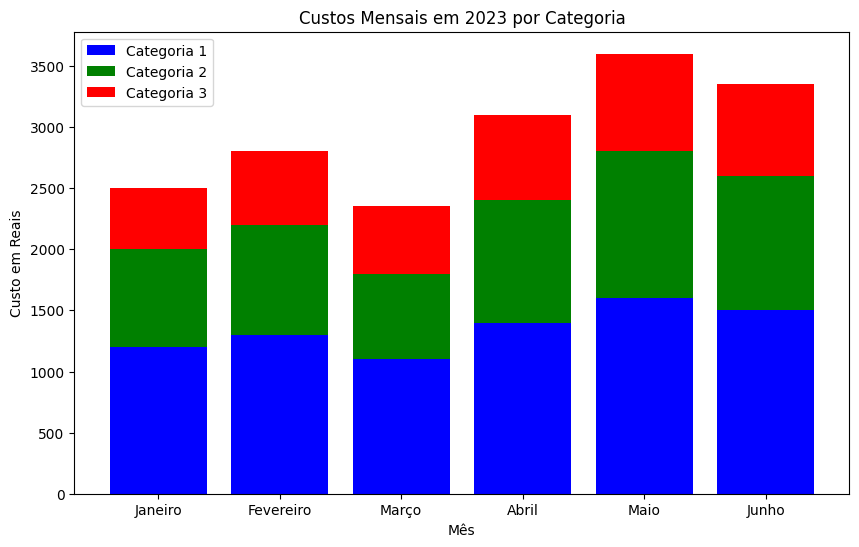

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Dados fictícios de custos mensais (substitua pelos seus próprios dados)
meses = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho']
custos1 = [1200, 1300, 1100, 1400, 1600, 1500]
custos2 = [800, 900, 700, 1000, 1200, 1100]
custos3 = [500, 600, 550, 700, 800, 750]

# Criar um gráfico de barras empilhadas
plt.figure(figsize=(10, 6))  # Definir o tamanho da figura (opcional)

plt.bar(meses, custos1, label='Categoria 1', color='blue')
plt.bar(meses, custos2, label='Categoria 2', bottom=custos1, color='green')
plt.bar(meses, custos3, label='Categoria 3', bottom=np.array(custos1) + np.array(custos2), color='red')

plt.xlabel('Mês')  # Rótulo do eixo x
plt.ylabel('Custo em Reais')  # Rótulo do eixo y
plt.title('Custos Mensais em 2023 por Categoria')  # Título do gráfico
plt.legend()  # Adicionar legenda

# Exibir o gráfico
plt.show()
